In [6]:
'''TO_DO
   0. Сообщить о том, что пример на 2 версии Питона
   0.5. Немного погрустить
   1. Уточнить про токенизацию
   2. Уточнить про создание тренировочного сета
   P.S. Дальше я вспомнил, что в jupyter notebook можно
   просто поменять тип ячейки, поэтому дальше вопросы будут рядом с кодом + комментариями в самом коде.
'''

'TO_DO'

In [1]:
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
import io #Добавил билиотеку для борьбы с проблемами декодинга
from datetime import datetime
from utils import * #Взял утилитарный файл с репозитория

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
nltk.download("book")

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Виктор\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\Виктор\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to
[nltk_data]    |     C:\Users\Виктор\AppData\Roaming\nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Виктор\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to
[nltk_data]    |     C:\Users\Виктор\AppData\Roaming\nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to
[nltk_data]    |     C:\Users\Виктор\App

True

In [3]:
vocabulary_size = 8000
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

# Преобразуем данные из дата-файла, расставляем токены SENTENCE_START и SENTENCE_END 
print ("Читаем CSV файл...")
with io.open('data/reddit-comments-2015-08.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f, skipinitialspace=True)
    next(reader)
    #Разделяем на предложения
    sentences = itertools.chain(*[nltk.sent_tokenize(x[0].lower()) for x in reader])
    #Расставляем токены
    sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
print ("Пропарсили %d предложений." % (len(sentences),)) 

# Разделяем предложения на слова
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

# Рассчитываем частоту появления слов
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print ("Найдено %d уникальных слов." % len(word_freq.items(),)) 

#Здесь непонятно, вроде мы должны выводить самые редкие слова?
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

print ("Итоговый размер условного словарного запаса %d." % (vocabulary_size,)) 
print ("Самое редко встречающееся слово '%s' появилось %d раз." % (vocab[-1][0], vocab[-1][1],)) 

# Все выведенные слова заменяем на токены UNKNOWN_TOKEN
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

print ("\nПример предложения: '%s'" % (sentences[0],) )
print ("\nПример предложения после пре-процессинга: '%s'" % (tokenized_sentences[0],)) 

Читаем CSV файл...
Пропарсили 79170 предложений.
Найдено 65499 уникальных слов.
Итоговый размер условного словарного запаса 8000.
Самое редко встречающееся слово 'documentary' появилось 10 раз.

Пример предложения: 'SENTENCE_START i joined a new league this year and they have different scoring rules than i'm used to. SENTENCE_END'

Пример предложения после пре-процессинга: '['SENTENCE_START', 'i', 'joined', 'a', 'new', 'league', 'this', 'year', 'and', 'they', 'have', 'different', 'scoring', 'rules', 'than', 'i', "'m", 'used', 'to', '.', 'SENTENCE_END']'


In [4]:
# Создаем тренировочный сет (тож не оч понятно)
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])

In [5]:
# Выводим пример 
x_example, y_example = X_train[17], y_train[17]
print ("x:\n%s\n%s" % (" ".join([index_to_word[x] for x in x_example]), x_example,))
print ("\ny:\n%s\n%s" % (" ".join([index_to_word[x] for x in y_example]), y_example,))

x:
SENTENCE_START what are n't you understanding about this ? !
[0, 51, 27, 16, 10, 857, 54, 25, 34, 69]

y:
what are n't you understanding about this ? ! SENTENCE_END
[51, 27, 16, 10, 857, 54, 25, 34, 69, 1]


Здесь появляются вопросы по теоретическому описанию итоговой модели РНН:
    1. Не очень понятен весь параграф про инициализацию, а точнее, насколько рандомные в итоге выбраны изначальные параметры
    2. Вопросы в определении функции Forward Propagation, которая вроде как отвечает за предугадывание вероятностей, относящихся к каждому слову

In [6]:
class RNNNumpy:
    
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        # Инициализируем(?) изначальные переменные
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Рандомно назначаем изначальные параметры сети
        self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))

In [7]:
def forward_propagation(self, x):
    # Общее количество шагов
    T = len(x)
    # Почему мы сохраняем в s матрицу нужной формы, но полную нулей?
    # Зачем нам нужен отдельный элемент, если в s мы все равно храним только внутренний слой?
    s = np.zeros((T + 1, self.hidden_dim))
    s[-1] = np.zeros(self.hidden_dim)
    # Сохраняем значения на выходе
    o = np.zeros((T, self.word_dim))
    for t in np.arange(T):
        # Здесь непонятно что происходит
        s[t] = np.tanh(self.U[:,x[t]] + self.W.dot(s[t-1]))
        o[t] = softmax(self.V.dot(s[t]))
    return [o, s]

RNNNumpy.forward_propagation = forward_propagation

In [8]:
def predict(self, x):
    # Как я понял, здесь мы получаем индекс максимально вероятного слова
    o, s = self.forward_propagation(x)
    return np.argmax(o, axis=1)

RNNNumpy.predict = predict

In [9]:
#Тестируем
np.random.seed(10)
model = RNNNumpy(vocabulary_size)
o, s = model.forward_propagation(X_train[10])
print (o.shape)
print (o)

(45, 8000)
[[0.00012408 0.0001244  0.00012603 ... 0.00012515 0.00012488 0.00012508]
 [0.00012536 0.00012582 0.00012436 ... 0.00012482 0.00012456 0.00012451]
 [0.00012387 0.0001252  0.00012474 ... 0.00012559 0.00012588 0.00012551]
 ...
 [0.00012472 0.0001243  0.00012524 ... 0.00012475 0.00012522 0.00012623]
 [0.00012564 0.00012431 0.00012481 ... 0.0001244  0.00012609 0.00012486]
 [0.00012447 0.00012509 0.00012469 ... 0.00012473 0.00012506 0.00012641]]


^И сразу вопросы: что обозначают полученные данные(вероятности, но комментарий все равно требуется), почему o = 45? 

In [10]:
#Тестируем predictions
predictions = model.predict(X_train[10])
print (predictions.shape)
print (predictions)

(45,)
[1284 5221 7653 7430 1013 3562 7366 4860 2212 6601 7299 4556 6892 3198
 5738 5853 2926  261  489  760 1810 5376 4146  477 7051 2060  238 4035
 3370 1835 3850 6176 5128 5879 4864 5132 6569 2800 2752 6821 4437 7021
 3943 6912 3922]


^Также требуется комментарий

In [11]:
def calculate_total_loss(self, x, y):
    L = 0
    # i - это предложения
    for i in np.arange(len(y)):
        o, s = self.forward_propagation(x[i])
        # Почему мы работаем только с предсказыванием корректного слова?
        correct_word_predictions = o[np.arange(len(y[i])), y[i]]
        # Прибавляем к ошибке значение, согласно выбранной функции ошибки
        L += -1 * np.sum(np.log(correct_word_predictions))
    return L

def calculate_loss(self, x, y):
    # Разделяем на части по количеству тренировочных примеров, далее я понял зачем
    N = np.sum((len(y_i) for y_i in y))
    return self.calculate_total_loss(x,y)/N

RNNNumpy.calculate_total_loss = calculate_total_loss
RNNNumpy.calculate_loss = calculate_loss

In [12]:
# Проверим на 1000 примеров
print ("Expected Loss for random predictions: %f" % (np.log(vocabulary_size),))
print ("Actual loss: %f" % (model.calculate_loss(X_train[:1000], y_train[:1000],)))

Expected Loss for random predictions: 8.987197
Actual loss: 8.987405


^Хороши ли полученные значения и разность между ними?

In [13]:
def bptt(self, x, y):
    T = len(y)
    # Инициализируем рямое распространение
    o, s = self.forward_propagation(x)
    # Какие значения после выполнения будут у градиентов(какого вида)?
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    # Чем будет являться массив delta_o?
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    # Идем циклом в обратную сторону, идем по полученным значениям?
    # но здесь нигде нет о, я что-то упустил
    for t in np.arange(T)[::-1]:
        # Мы умножаем каждый элемент массива дель на соответствующий элемент массива значений внутреннего слоя?
        dLdV += np.outer(delta_o[t], s[t].T)
        # Дальнейшие вычисления непонятны, скорее всего из-за непонимания в начале
        delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
        # Почему мы можем рассчитать градиенты внутреннего цикла и связи с входом вместе?
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
            # оставил на всякий случай
            dLdW += np.outer(delta_t, s[bptt_step-1])              
            dLdU[:,x[bptt_step]] += delta_t
            # Пересчитываем дельта t
            delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdU, dLdV, dLdW]

RNNNumpy.bptt = bptt

In [14]:
def gradient_check(self, x, y, h=0.001, error_threshold=0.01):
    # Производим рассчет значений градиентов
    bptt_gradients = model.bptt(x, y)
    # Перечисляем проверяемые параметры
    model_parameters = ['U', 'V', 'W']
    # Сама проверка
    for pidx, pname in enumerate(model_parameters):
        # Выбираем параметр
        parameter = operator.attrgetter(pname)(self)
        print ("Проверяем значение градиента для параметра %s с размером %d." % (pname, np.prod(parameter.shape),))
        # Что мы делаем здесь я понял, но не понял сам принцип работы .nditer
        it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index
            # Сохраняем изначальное значение
            original_value = parameter[ix]
            # Непонятно что мы делаем здесь?
            parameter[ix] = original_value + h
            gradplus = model.calculate_total_loss([x],[y])
            parameter[ix] = original_value - h
            gradminus = model.calculate_total_loss([x],[y])
            estimated_gradient = (gradplus - gradminus)/(2*h)
            # Возвращаем к изначальному значению
            parameter[ix] = original_value
            # Используем обратное распространение для расчета градиента, но почему?
            backprop_gradient = bptt_gradients[pidx][ix]
            # Рассчитываем ошибку (что значит relative?): (|x - y|/(|x| + |y|))
            relative_error = np.abs(backprop_gradient - estimated_gradient)/(np.abs(backprop_gradient) + np.abs(estimated_gradient))
            # При слишком большом значении ошибки выводим сообщение об ошибке
            if relative_error > error_threshold:
                print ("Проверка значения градиента ERROR: параметр=%s ix=%s" % (pname, ix,))
                print ("+h Ошибка: %f" % (gradplus,))
                print ("-h Ошибка: %f" % (gradminus,))
                print ("Estimated_gradient: %f" % (estimated_gradient,))
                print ("Backpropagation gradient: %f" % (backprop_gradient,))
                print ("Relative Error: %f" % (relative_error,))
                return 
            it.iternext()
        print ("Проверка значения градиента параметра %s пройдена." % (pname,))

RNNNumpy.gradient_check = gradient_check

# Проверяем на меньшем наборе данных
grad_check_vocab_size = 100
np.random.seed(10)
model = RNNNumpy(grad_check_vocab_size, 10, bptt_truncate=1000)
model.gradient_check([0,1,2,3], [1,2,3,4])

Проверяем значение градиента для параметра U с размером 1000.
Проверка значения градиента параметра U пройдена.
Проверяем значение градиента для параметра V с размером 1000.
Проверка значения градиента параметра V пройдена.
Проверяем значение градиента для параметра W с размером 100.
Проверка значения градиента параметра W пройдена.


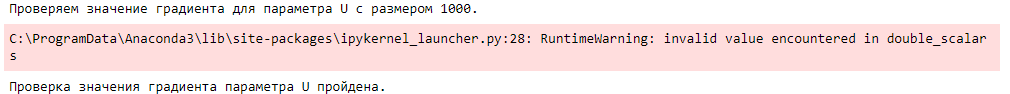
При втором запуске ошибка пропала

In [15]:
# Один шаг градиентного спуска.
def numpy_sdg_step(self, x, y, learning_rate): #Ошибка или нет, sdg вместо sgd
    # Рассчитываем градиенты
    dLdU, dLdV, dLdW = self.bptt(x, y)
    # Пересчитываем параметры согласно значениям градиентов и ?обучаемости?
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW

RNNNumpy.sgd_step = numpy_sdg_step

In [16]:
# Outer SGD Loop
# - model: The RNN model instance
# - X_train: The training data set
# - y_train: The training data labels
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
# - evaluate_loss_after: Evaluate the loss after this many epochs
# не стал переводить, так как не уверен в том, что правильно понял
def train_with_sgd(model, X_train, y_train, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
    # Собираем значения оишбки
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Оцениваем значение ошибки
        if (epoch % evaluate_loss_after == 0):
            loss = model.calculate_loss(X_train, y_train)
            losses.append((num_examples_seen, loss))
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print ("%s: Ошибка после num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss,))
            # Половиним темпы обучения при повышении ошибки, но почему именно пополам?
            if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                learning_rate = learning_rate * 0.5  
                print ("Выставляем темп обучения на %f" % (learning_rate,))
            sys.stdout.flush()
        # Для каждого примера
        for i in range(len(y_train)):
            # Пошагово
            model.sgd_step(X_train[i], y_train[i], learning_rate)
            num_examples_seen += 1

In [17]:
np.random.seed(10)
model = RNNNumpy(vocabulary_size)
%timeit model.sgd_step(X_train[10], y_train[10], 0.005)

222 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Получилось 216 мс на шаг, поменьше чем в примере, но все равно запускать я это конечно не буду

In [45]:
np.random.seed(10)
# Просто проверка работоспособности на малом кол-ве примеров
model = RNNNumpy(vocabulary_size)
losses = train_with_sgd(model, X_train[:100], y_train[:100], nepoch=10, evaluate_loss_after=1)

2018-03-22 00:25:48: Ошибка после num_examples_seen=0 epoch=0: 8.987411
2018-03-22 00:25:59: Ошибка после num_examples_seen=100 epoch=1: 8.976174
2018-03-22 00:26:09: Ошибка после num_examples_seen=200 epoch=2: 8.960025
2018-03-22 00:26:20: Ошибка после num_examples_seen=300 epoch=3: 8.930062
2018-03-22 00:26:30: Ошибка после num_examples_seen=400 epoch=4: 8.858373
2018-03-22 00:26:41: Ошибка после num_examples_seen=500 epoch=5: 6.869721
2018-03-22 00:26:52: Ошибка после num_examples_seen=600 epoch=6: 6.306325
2018-03-22 00:27:03: Ошибка после num_examples_seen=700 epoch=7: 6.030856
2018-03-22 00:27:13: Ошибка после num_examples_seen=800 epoch=8: 5.855262
2018-03-22 00:27:24: Ошибка после num_examples_seen=900 epoch=9: 5.734254


В итоге ошибка уменьшается
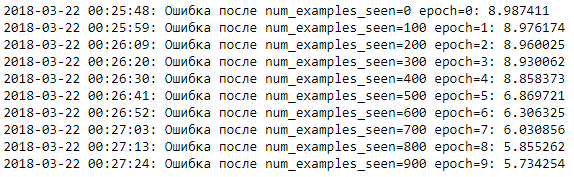

Чтобы следующие блоки кода начали работать, я через Anaconda Navigator докачал пакеты theano и keras

In [18]:
# Часть с обучением через Theano я пропускаю
# просто добавляю в проект обученную сеть
from rnn_theano import RNNTheano, gradient_check_theano
from utils import load_model_parameters_theano, save_model_parameters_theano

model = RNNTheano(vocabulary_size, hidden_dim=50)
# losses = train_with_sgd(model, X_train, y_train, nepoch=50)
# save_model_parameters_theano('./data/trained-model-theano.npz', model)
load_model_parameters_theano('./data/trained-model-theano.npz', model)

C:\Users\Виктор\AnacondaProjects\MyProj\rnn_theano.py:32: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  o_t = T.nnet.softmax(V.dot(s_t))
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Loaded model parameters from ./data/trained-model-theano.npz. hidden_dim=50 word_dim=8000


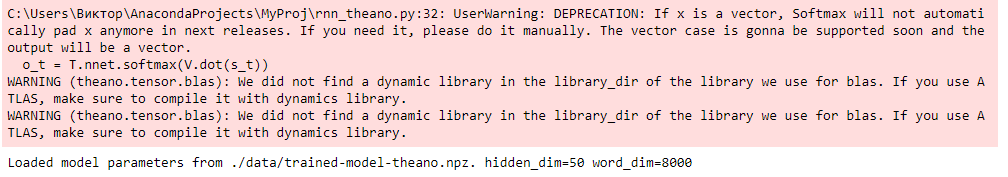

In [19]:
def generate_sentence(model):
    # Начинаем предложение со стартового токена
    new_sentence = [word_to_index[sentence_start_token]]
    # Продолжаем собирать предложение, пока не дойдем до токена конца
    while not new_sentence[-1] == word_to_index[sentence_end_token]:
        next_word_probs = model.forward_propagation(new_sentence)
        sampled_word = word_to_index[unknown_token]
        # We don't want to sample unknown words - Здесь неясно почему
        while sampled_word == word_to_index[unknown_token]:
            samples = np.random.multinomial(1, next_word_probs[-1])
            sampled_word = np.argmax(samples)
        new_sentence.append(sampled_word)
    sentence_str = [index_to_word[x] for x in new_sentence[1:-1]]
    return sentence_str

num_sentences = 10
senten_min_length = 7

for i in range(num_sentences):
    sent = []
    # Устанавливаем границу на минимальное количество слов в предложении
    while len(sent) < senten_min_length:
        sent = generate_sentence(model)
    print (" ".join(sent))

no to connection their stuff go at all .
luck limit number 2fr but angry every game .
no basically work on the partners 3d a implies 6. .
the owns what is needed hard .
me do you near getting bros .
cock is much did , no .
me so many different glad topic .
probably not very a bot or partner .
save this is chart so why ?
veigar but a magical gun sucks .


no to connection their stuff go at all .
luck limit number 2fr but angry every game .
no basically work on the partners 3d a implies 6. .
the owns what is needed hard .
me do you near getting bros .
c-ck is much did , no .
me so many different glad topic .
probably not very a bot or partner .
save this is chart so why ?
veigar but a magical gun s-cks .

Две точки похожи на ошибку. Дефисы - цензура.
В целом работает, но не хватает понимания почему, необходима консультация.